# Ensemble Techniques
Ensemble of weak learners trained on different balanced bootstrap samples.

- Balanced Bagging Classifier 
    - Decision Tree Classifier
    - Support Vector Classifier
    - Logistic Regression
 

In [1]:
import warnings
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

df_train = pd.read_csv('train.csv')
X_test   = pd.read_csv('test.csv', usecols =['value', 'predicted'])

# Data Pre-processing
df_train['is_anomaly'] = np.where(df_train['is_anomaly'] == False, 0, 1) 
df_train["Is_anomaly"] = df_train['is_anomaly'].values

df_train.drop('is_anomaly', axis = 1 ,inplace = True)

X_train = df_train[['value','predicted']]
y_train = df_train['Is_anomaly']
df_train.head(10)

,timestamp,value,predicted,Is_anomaly
0,1425008573,42,44.072500,0
1,1425008873,41,50.709390,0
2,1425009173,41,81.405120,0
3,1425009473,61,39.950367,0
4,1425009773,44,35.350160,0
5,1425010073,27,27.713638,0
6,1425010373,37,41.545710,0
7,1425010673,36,38.743620,0
8,1425010973,49,40.859787,0
9,1425011273,36,25.444733,0


- Define plot functions

In [2]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

In [3]:
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step), copy = True
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

- Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

std_scaler = StandardScaler()
mmx_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

# Create scaled datasets 
X_train_S = pd.DataFrame(std_scaler.fit_transform(X_train))
X_train_R = pd.DataFrame(rob_scaler.fit_transform(X_train))
X_train_M = pd.DataFrame(mmx_scaler.fit_transform(X_train))

X_test_S = pd.DataFrame(std_scaler.transform(X_train))
X_test_R = pd.DataFrame(rob_scaler.transform(X_train))
X_test_M = pd.DataFrame(mmx_scaler.transform(X_train))

- Hyper-parameter tunning (with Min-Max Scaling)

In [18]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold 

# Specify different values for the tunning process
StratifiedKFold = RepeatedStratifiedKFold(n_splits     = 5, 
                                          n_repeats    = 2, 
                                          random_state = 99)

base_estimator     = [LogisticRegression(), DecisionTreeClassifier(), SVC()]
n_estimators       = [5, 10, 50]
bootstrap          = [True, False]
warm_start         = [True, False]
sampling_strategy  = ['auto']
sampler            = [RandomUnderSampler(), NearMiss()]

#Create parameter grid
balanced_grid = [{'base_estimator'    : base_estimator,
                  'n_estimators'      : n_estimators, 
                  'bootstrap'         : bootstrap,
                  'warm_start'        : warm_start, 
                  'sampling_strategy' : sampling_strategy,
                  'sampler'           : sampler}]

#Create SVR object
balanced_model  = BalancedBaggingClassifier()

#Grid Search CV
balanced_search = GridSearchCV(balanced_model, 
                           balanced_grid, 
                           scoring= 'f1', 
                           cv = StratifiedKFold, 
                           verbose= True).fit(X_train_M, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [19]:
balanced_search.best_params_

{'base_estimator': SVC(),
 'bootstrap': True,
 'n_estimators': 5,
 'sampler': RandomUnderSampler(),
 'sampling_strategy': 'auto',
 'warm_start': True}

- Specify Optimal Balanced Model

In [10]:
optimal_model = BalancedBaggingClassifier(base_estimator = SVC(),
                                          bootstrap      = True,
                                          n_estimators   = 5,
                                          sampler        = RandomUnderSampler(),
                                          sampling_strategy = 'auto',
                                          warm_start        = False)

- Plot different models

In [15]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

model_Imbalanced = LogisticRegression().fit(X_train_M, y_train)
balance_log = BalancedBaggingClassifier(base_estimator = LogisticRegression(),
                                          bootstrap      = True,
                                          n_estimators   = 5,
                                          sampler        = NearMiss(),
                                          sampling_strategy = 'auto',
                                          warm_start        = True).fit(X_train_M,y_train)
balance_tree = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                          bootstrap      = True,
                                          n_estimators   = 5,
                                          sampler        = RandomUnderSampler(),
                                          sampling_strategy = 'auto',
                                          warm_start        = True).fit(X_train_M,y_train)
optimal_model = BalancedBaggingClassifier(base_estimator = SVC(),
                                          bootstrap      = True,
                                          n_estimators   = 5,
                                          sampler        = RandomUnderSampler(),
                                          sampling_strategy = 'auto',
                                          warm_start        = False).fit(X_train_M,y_train)


y_pred_log   = balance_log.predict(X_test_M)
y_pred_tree  = balance_tree.predict(X_test_M)
y_pred_opt   = optimal_model.predict(X_test_M)

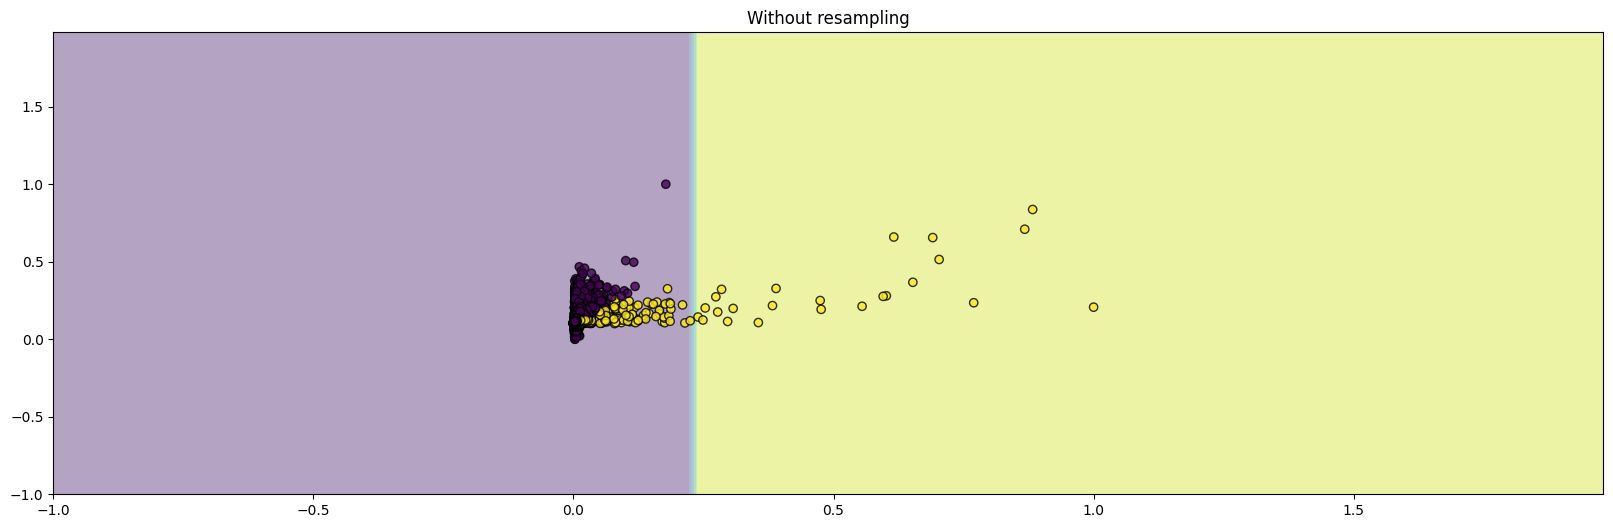

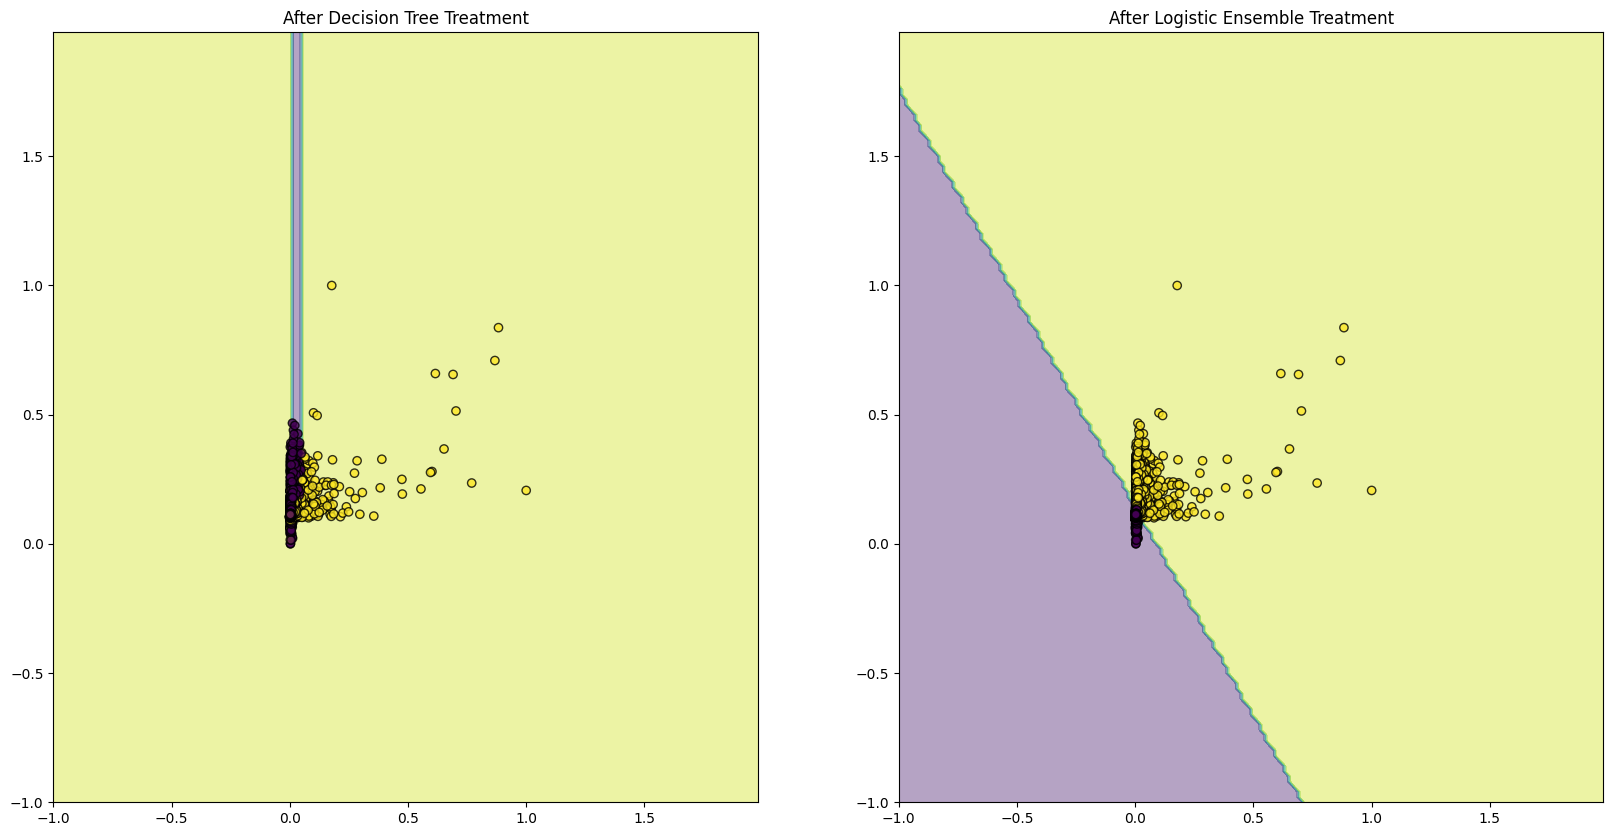

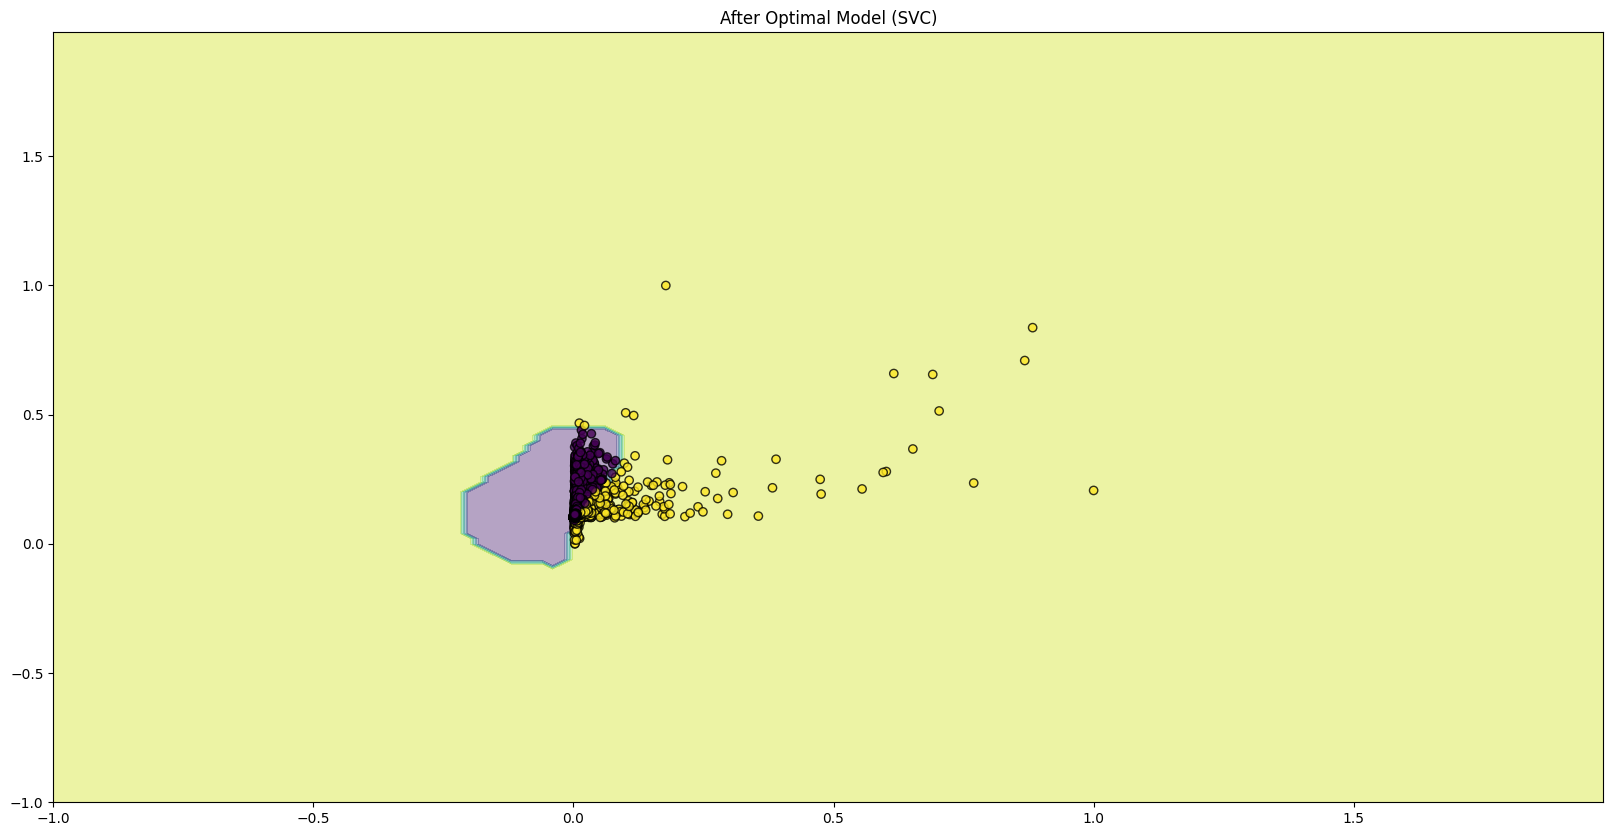

In [17]:
fig, ax = plt.subplots( figsize=(20, 6))
plot_decision_function(X_train_M.to_numpy(), y_train.to_numpy(), model_Imbalanced, ax, title="Without resampling")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plot_decision_function(X_test_M.to_numpy(), y_pred_tree, balance_tree, axs[0], title="After Decision Tree Treatment")
plot_decision_function(X_test_M.to_numpy(), y_pred_log, balance_log, axs[1], title="After Logistic Ensemble Treatment")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plot_decision_function(X_test_M.to_numpy(), y_pred_opt, optimal_model, axs, title="After Optimal Model (SVC)")